![ups logo](https://upload.wikimedia.org/wikipedia/commons/thumb/b/b0/Logo_Universidad_Polit%C3%A9cnica_Salesiana_del_Ecuador.png/640px-Logo_Universidad_Polit%C3%A9cnica_Salesiana_del_Ecuador.png)

# Inteligencia Artificial

# Practica 05

## Aplicaciones de las Redes Neuronales y Bayesianas como herramientas de soporte a la toma de decisiones. Despliegue de servicios de Inteligencia Artificial

### Autor: Diego Tapia

## Desarrollo

#### Esta practica se divide en siete partes:

1. Fase de preparación

2. **Fase de modelado: Red Neuronal**

3. Fase de modelado: Naive Bayes

4. Comparacion de modelos

5. Fase de predicción de nuevos samples (Red Neuronal y Naive Bayes)

6. Proyecto en Django Framework

7. Despliegue del proyecto


In [1]:
# Importacion de librerias

%pip install scikeras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from time import time
from datetime import datetime, timedelta

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle
import seaborn as sns
import copy

from sklearn.model_selection import train_test_split
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from keras.layers import Dropout

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.models import model_from_json
from keras.models import load_model

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn import set_config

print("Módulos y clases importados")

Módulos y clases importados


## Fase 2. Modelo de Red Neuronal

### Importacion de recursos

Se carga el pipeline de la Fase 1

In [2]:
def cargarPipeline(nombreArchivo):
    with open(nombreArchivo+'.pickle', 'rb') as handle:
        pipeline = pickle.load(handle)
    return pipeline

In [3]:
pipe = cargarPipeline('pipeline_bank_data')
pipe

Pipeline(steps=[('prepcn',
                 ColumnTransformer(n_jobs=-1, remainder='passthrough',
                                   transformers=[('catord',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['education']),
                                                 ('catnom',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['job', 'marital',
                                                   'contact'])])),
                ('prepstandard',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('transcaler',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21, 22, 23,
                                                   24])]))])

Se carga el dataset preparado de la fase 1

In [4]:
dataframe = pd.read_csv("dataset_preparado.csv", sep=";", header=0)
dataframe.head()

,age,job,marital,education,balance,housing,loan,contact,duration,campaign,result
0,58,management,married,tertiary,2143,1,0,unknown,261,1,0
1,44,technician,single,secondary,29,1,0,unknown,151,1,0
2,33,entrepreneur,married,secondary,2,1,1,unknown,76,1,0
3,47,blue-collar,married,unknown,1506,1,0,unknown,92,1,0
4,33,unknown,single,unknown,1,0,0,unknown,198,1,0


Separacion de la variable independiente (objetivo) y las variables dependientes

In [5]:
Y = dataframe['result']
dataframe.drop('result', axis=1, inplace=True)
Y.head()

0    0
1    0
2    0
3    0
4    0
Name: result, dtype: int64

In [6]:
X=copy.deepcopy(dataframe)
X.head()

,age,job,marital,education,balance,housing,loan,contact,duration,campaign
0,58,management,married,tertiary,2143,1,0,unknown,261,1
1,44,technician,single,secondary,29,1,0,unknown,151,1
2,33,entrepreneur,married,secondary,2,1,1,unknown,76,1
3,47,blue-collar,married,unknown,1506,1,0,unknown,92,1
4,33,unknown,single,unknown,1,0,0,unknown,198,1


Se identifica la cantidad de variables para crear la capa de entrada de la red neuronal

In [7]:
nombrePrep='prepstandard'
cantidadVariablesIndependientesNN = len(pipe.named_steps[nombrePrep].transformers_[0][2])
print("\nCantidad de variables después de preprocesamiento: ",cantidadVariablesIndependientesNN)


Cantidad de variables después de preprocesamiento:  25


### Modelado de la Red Neuronal

In [8]:
import keras
from keras.layers import Dense

In [9]:
def build_model():
    model = Sequential()
    model.add(Dense(25, input_shape=(cantidadVariablesIndependientesNN,), activation='relu'))
    model.add(Dense(50, activation='relu'))  # Capa oculta
    model.add(Dense(100, activation='relu'))  # Capa oculta
    model.add(Dense(100, activation='relu'))  # Capa oculta
    model.add(Dense(100, activation='relu'))  # Capa oculta
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

modelo_NN = build_model()
print("Modelo de red neuronal creado")

#Se inserta el modelo como paso final del pipeline
pipe.steps.append(['modelNN',modelo_NN])
#pipe.steps.pop()
print("Cantidad de pasos: ",len(pipe.steps))
pipe.named_steps['modelNN'].summary()

Modelo de red neuronal creado
Cantidad de pasos:  3
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 25)                650       
                                                                 
 dense_1 (Dense)             (None, 50)                1300      
                                                                 
 dense_2 (Dense)             (None, 100)               5100      
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 1)                 101       
                                                                 
Tota

### Entrenamiento red neuronal


Para entrenar la red neuronal, se utiliza la técnica de validación cruzada o K-Folding, debido a la cantidad de datos (45211).

In [10]:
# Función para transformar la predicción
def transformarPrediccion(lista):
    for i in range(len(lista)):
        desempenio=lista[i]
        #print(desempenio)
        if (desempenio < 0.5):
            desempenio = 0
        elif (desempenio >= 0.5):
            desempenio = 1
        lista[i]=desempenio
    return lista

In [11]:
from sklearn.utils import class_weight
from sklearn.model_selection import StratifiedKFold
from keras.models import Sequential
from sklearn.metrics import accuracy_score

# K-fold Cross Validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
resultados_acumulados = []
for train_index, val_index in kfold.split(X,Y):
  X_train, X_val = X.iloc[train_index], X.iloc[val_index]
  y_train, y_val = Y.iloc[train_index], Y.iloc[val_index]

  # Entrenamiento de la red neuronal
  pipe.fit(X_train, y_train, modelNN__epochs=100, modelNN__batch_size=1024, modelNN__verbose=0)

  # predicion con el conjunto de validacion
  y_pred = pipe.predict(X_val)

  # Evaluacion de la precisión en el conjunto de validacion
  acc = accuracy_score(y_val, transformarPrediccion(y_pred))
  resultados_acumulados.append(acc)

print("Resultados validacion cruzada: \n", resultados_acumulados)
print("Precision media: ", np.mean(resultados_acumulados))
print('Modelo Red neuronal entrenado')

283/283 [==============================] - 0s 1ms/step
Resultados validacion cruzada: 
 [0.8774742895056951, 0.8796726387967264, 0.9035611590356116, 0.9182702941827029, 0.9277814642778146]
Precision media:  0.9013519691597102
Modelo Red neuronal entrenado


### Predicción con el conjunto de Test

In [12]:

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)
y_pred = pipe.predict(X_test)
y_pred = y_pred.flatten()
y_pred = transformarPrediccion(y_pred)
dataframeFinal_NN_con_transformacion=pd.DataFrame({'real':y_test, 'predicción clase': y_pred})
np.set_printoptions(formatter={'float': lambda X: "{0:0.0f}".format(X)})
dataframeFinal_NN_con_transformacion.head(10)

283/283 [==============================] - 0s 1ms/step


,real,predicción clase
3776,0,0.0
9928,0,0.0
33409,0,0.0
31885,0,0.0
15738,0,0.0
30813,0,0.0
35463,0,0.0
31382,0,0.0
16904,0,0.0
11930,0,0.0


### Evaluación de la calidad de la Red Neuronal

Mean Absolute Error (MAE): 0.0288
Mean Squared Error (MSE): 0.0288
Root Mean Squared Error (RMSE): 0.1696
Accuracy: 0.971248479486896
Precision:  0.8938
Recall:  0.8643
F1: 0.8788
Matriz de confusión:
Verdaderos negativos:  7840  Falsos positivos:  112  Falsos negativos:  148  Verdaderos positivos:  943


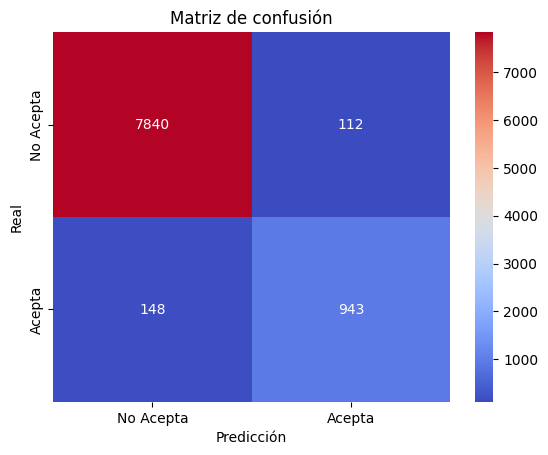

In [13]:
MAE=metrics.mean_absolute_error(y_test, y_pred)
MSE=metrics.mean_squared_error(y_test, y_pred)
RMSE=np.sqrt(metrics.mean_squared_error(y_test, y_pred))

MAE=str(round(MAE, 4))
MSE=str(round(MSE, 4))
RMSE=str(round(RMSE, 4))

print('Mean Absolute Error (MAE):', MAE)
print('Mean Squared Error (MSE):', MSE)
print('Root Mean Squared Error (RMSE):', RMSE)

y_testBinario = (y_test >= 0.5).astype("int32")
y_predBinario = (y_pred >= 0.5).astype("int32")

#y_pred=y_pred.flatten()# de 2D a 1D

accuracyModeloBase=str(accuracy_score(y_testBinario, y_predBinario))
print('Accuracy: ' + accuracyModeloBase)

precision=precision_score(y_testBinario, y_predBinario)
precision=str(round(precision, 4))
print('Precision: ',precision)

recall=recall_score(y_testBinario, y_predBinario)
recall=str(round(recall, 4))
print('Recall: ',recall)

f1=f1_score(y_testBinario, y_predBinario)
f1=str(round(f1, 4))
print('F1:',f1)

print('Matriz de confusión:')
tn, fp, fn, tp = confusion_matrix(y_testBinario, y_predBinario).ravel()
print('Verdaderos negativos: ',tn,' Falsos positivos: ',fp,' Falsos negativos: ',fn,' Verdaderos positivos: ',tp)

from sklearn.metrics import confusion_matrix
labels = ['No Acepta', 'Acepta']
cm = confusion_matrix(y_testBinario, y_predBinario)
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='coolwarm', fmt='g');
ax.set_xlabel('Predicción');ax.set_ylabel('Real');
ax.set_title('Matriz de confusión');
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

### Exportar Red Neuronal

In [14]:

def guardarRedNeuronal(modelo, nombreArchivo):
    # Guardar el modelo de la red neuronal en formato .h5
    modelo.save(nombreArchivo + '.h5')


guardarRedNeuronal(modelo_NN, 'model_NN_bank_data')
print("red neuronal guardada")


red neuronal guardada


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
